# Milestone 1: Tackling big data on your laptop

## Authors: Neel Phaterpekar, Arash Shamseddini and Charles Suresh

In [1]:
import requests
import json
import os
from urllib.request import urlretrieve
import zipfile
import glob
import pandas as pd
import re
from memory_profiler import memory_usage
import pyarrow.dataset as ds
import pyarrow.feather as feather
import pyarrow.parquet as pq
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import rpy2_arrow.pyarrow_rarrow as pyra

In [2]:
%load_ext rpy2.ipython
%load_ext memory_profiler

In [3]:
%%R
library(dplyr)
library(arrow)

R[write to console]: 
Attaching package: ‘dplyr’


R[write to console]: The following objects are masked from ‘package:stats’:

    filter, lag


R[write to console]: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




## 1. Downloading the data

### 1.1 Download data from figshare

In [4]:
article_id = 14096681  # this is the unique identifier of the article on figshare
url = f"https://api.figshare.com/v2/articles/{article_id}"
headers = {"Content-Type": "application/json"}
output_directory = "figsharerainfall/"

In [5]:
%%time
%memit
response = requests.request("GET", url, headers=headers)
data = json.loads(response.text)  # this contains all the articles data, feel free to check it out
files = data["files"]             # this is just the data about the files, which is what we want
files

peak memory: 328.65 MiB, increment: 0.15 MiB
CPU times: user 75.5 ms, sys: 39.3 ms, total: 115 ms
Wall time: 3.08 s


[{'is_link_only': False,
  'name': 'daily_rainfall_2014.png',
  'supplied_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'computed_md5': 'fd32a2ffde300a31f8d63b1825d47e5e',
  'id': 26579150,
  'download_url': 'https://ndownloader.figshare.com/files/26579150',
  'size': 58863},
 {'is_link_only': False,
  'name': 'environment.yml',
  'supplied_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'computed_md5': '060b2020017eed93a1ee7dd8c65b2f34',
  'id': 26579171,
  'download_url': 'https://ndownloader.figshare.com/files/26579171',
  'size': 192},
 {'is_link_only': False,
  'name': 'README.md',
  'supplied_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'computed_md5': '61858c6cc0e6a6d6663a7e4c75bbd88c',
  'id': 26586554,
  'download_url': 'https://ndownloader.figshare.com/files/26586554',
  'size': 5422},
 {'is_link_only': False,
  'name': 'data.zip',
  'supplied_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'computed_md5': 'b517383f76e77bd03755a63a8ff83ee9',
  'id': 26766812,
  'download_url': 'https://

In [6]:
%%time
files_to_dl = ["data.zip"] # need only this zip file
for file in files:
    if file["name"] in files_to_dl:
        os.makedirs(output_directory, exist_ok=True) # create the folder if not exists
        urlretrieve(file["download_url"], output_directory + file["name"])

CPU times: user 2.38 s, sys: 2.08 s, total: 4.46 s
Wall time: 59.9 s


### 1.2 Unzipping Files 

In [7]:
%%time
%memit
with zipfile.ZipFile(os.path.join(output_directory, "data.zip"), 'r') as f:
    f.extractall(output_directory)

peak memory: 331.91 MiB, increment: 0.00 MiB
CPU times: user 15.3 s, sys: 2.27 s, total: 17.5 s
Wall time: 19.9 s


### 1.3 Observations


| Contributors | Downloading wall time  | Extracting wall time  | 
|:---:|:-----:|:--------:|
| Neel   |   1min 10s   |  23 s      | 
| Arash   | 10min 12s    | 26.6 s         |  
| Charles   | 59.9s   |    19.9s      |


> Suprisingly Arash's time usage for downloading the data.zip was significantly larger than those for Neel and Charles.

## 2. Combining data CSVs

In [8]:
%%time
%memit

files = glob.glob('figsharerainfall/*.csv')

df = pd.concat((pd.read_csv(file, header=0, index_col=0)
                .assign(model=file[file.rfind("\\")+1:file.index("_daily")]) # Discuss this with others
                for file in files))

df.to_csv("figsharerainfall/combined_data.csv")

peak memory: 329.69 MiB, increment: 0.00 MiB
CPU times: user 5min 18s, sys: 11 s, total: 5min 29s
Wall time: 5min 32s


In [9]:
%%sh
du -sh figsharerainfall/combined_data.csv

6.6G	figsharerainfall/combined_data.csv


### 2.1. Summary table

| Contributors | Combining data wall time  | combined_data.csv memory usage  | 
|:---:|:-----:|:--------:|
| Neel   |   6min 51s   |  5.6G      | 
| Arash   | 6min 10s    | 5.7G         |  
| Charles   | 5min 32s   |   6.6G       |


### 2.2. Discussing observations

> Both run times and memory usages on different machines within the team are pretty similar

> Time usage: 5-7 min

> Memory usage: 5.5-6.6G

## 3. Load the combined CSV to memory and performing a simple EDA

In [10]:
%%time
%%memit
df_float64 = pd.read_csv("figsharerainfall/combined_data.csv")

peak memory: 9503.02 MiB, increment: 5726.89 MiB
CPU times: user 54.3 s, sys: 9.78 s, total: 1min 4s
Wall time: 1min 6s


### 3.1.1 Investigating Memory Reduction Approaches

#### Changing dtype of data:

In [11]:
df_float32 = df_float64.astype('float32', errors='ignore')

In [12]:
print(f"Memory usage with float64: {df_float64.memory_usage().sum() / 1e6:.2f} MB")
print(f"Memory usage with float32: {df_float32.memory_usage().sum() / 1e6:.2f} MB")

Memory usage with float64: 3500.78 MB
Memory usage with float32: 2250.50 MB


> Memory usage with float32 (2250.50 MB) is much lower than the memory usage with float64 (3500.78 MB).

####  Using Dask:

In [13]:
%%time
%%memit
ddf = dd.read_csv('figsharerainfall/combined_data.csv', blocksize=25e6)

peak memory: 8389.09 MiB, increment: -9.72 MiB
CPU times: user 109 ms, sys: 204 ms, total: 313 ms
Wall time: 1.7 s


In [14]:
cols = ['lat_min', 'lat_max', 'lon_min', 'lon_max', 'rain (mm/day)']
ddf[cols] = ddf[cols].astype('float32')

### 3.1.2 Python Simple EDA

#### 3.1.2.1 Value Counts of `model`:

##### Pandas DataFrame:

In [15]:
%%time
%%memit
print(df_float32[["model"]].value_counts())

model                            
figsharerainfall/MPI-ESM1-2-HR       5154240
figsharerainfall/TaiESM1             3541230
figsharerainfall/CMCC-CM2-HR4        3541230
figsharerainfall/CMCC-CM2-SR5        3541230
figsharerainfall/CMCC-ESM2           3541230
figsharerainfall/NorESM2-MM          3541230
figsharerainfall/SAM0-UNICON         3541153
figsharerainfall/FGOALS-f3-L         3219300
figsharerainfall/GFDL-CM4            3219300
figsharerainfall/GFDL-ESM4           3219300
figsharerainfall/EC-Earth3-Veg-LR    3037320
figsharerainfall/MRI-ESM2-0          3037320
figsharerainfall/BCC-CSM2-MR         3035340
figsharerainfall/MIROC6              2070900
figsharerainfall/ACCESS-CM2          1932840
figsharerainfall/ACCESS-ESM1-5       1610700
figsharerainfall/INM-CM4-8           1609650
figsharerainfall/INM-CM5-0           1609650
figsharerainfall/KIOST-ESM           1287720
figsharerainfall/FGOALS-g3           1287720
figsharerainfall/MPI-ESM-1-2-HAM      966420
figsharerainfall/MPI-

##### Dask DataFrame:

In [16]:
%%time
%%memit
print(ddf["model"].value_counts().compute())

figsharerainfall/MPI-ESM1-2-HR       5154240
figsharerainfall/TaiESM1             3541230
figsharerainfall/CMCC-CM2-HR4        3541230
figsharerainfall/CMCC-CM2-SR5        3541230
figsharerainfall/CMCC-ESM2           3541230
figsharerainfall/NorESM2-MM          3541230
figsharerainfall/SAM0-UNICON         3541153
figsharerainfall/FGOALS-f3-L         3219300
figsharerainfall/GFDL-CM4            3219300
figsharerainfall/GFDL-ESM4           3219300
figsharerainfall/EC-Earth3-Veg-LR    3037320
figsharerainfall/MRI-ESM2-0          3037320
figsharerainfall/BCC-CSM2-MR         3035340
figsharerainfall/MIROC6              2070900
figsharerainfall/ACCESS-CM2          1932840
figsharerainfall/ACCESS-ESM1-5       1610700
figsharerainfall/INM-CM4-8           1609650
figsharerainfall/INM-CM5-0           1609650
figsharerainfall/KIOST-ESM           1287720
figsharerainfall/FGOALS-g3           1287720
figsharerainfall/MPI-ESM-1-2-HAM      966420
figsharerainfall/MPI-ESM1-2-LR        966420
figsharera

##### Loading in Chunks:

In [17]:
%%time
%%memit
counts = pd.Series(dtype=int)
for chunk in pd.read_csv("figsharerainfall/combined_data.csv", chunksize=10_000_000):
    counts = counts.add(chunk["model"].value_counts(), fill_value=0)
print(counts.astype(int))

figsharerainfall/ACCESS-CM2          1932840
figsharerainfall/ACCESS-ESM1-5       1610700
figsharerainfall/AWI-ESM-1-1-LR       966420
figsharerainfall/BCC-CSM2-MR         3035340
figsharerainfall/BCC-ESM1             551880
figsharerainfall/CMCC-CM2-HR4        3541230
figsharerainfall/CMCC-CM2-SR5        3541230
figsharerainfall/CMCC-ESM2           3541230
figsharerainfall/CanESM5              551880
figsharerainfall/EC-Earth3-Veg-LR    3037320
figsharerainfall/FGOALS-f3-L         3219300
figsharerainfall/FGOALS-g3           1287720
figsharerainfall/GFDL-CM4            3219300
figsharerainfall/GFDL-ESM4           3219300
figsharerainfall/INM-CM4-8           1609650
figsharerainfall/INM-CM5-0           1609650
figsharerainfall/KIOST-ESM           1287720
figsharerainfall/MIROC6              2070900
figsharerainfall/MPI-ESM-1-2-HAM      966420
figsharerainfall/MPI-ESM1-2-HR       5154240
figsharerainfall/MPI-ESM1-2-LR        966420
figsharerainfall/MRI-ESM2-0          3037320
figsharera

##### Observations:

|                  | Peak Memory | CPU Time | Wall Time |
|:----------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame |9312.58 MB  |  5.16s     |   5.16s        |
|  Dask DataFrame  | 8822.06 MB |2min 12s     | 45.8          |
|  Loading in Chunks| 6144.35 MB  |    1min 7s   |   1min 8s    |

When calling `value_counts` function:
- By using Dask DataFrame over Pandas DataFrame, we see that the Peak Memory drops by a considerable amount
- However, the CPU and Wall Times are quite a bit higher when using Dask DataFrame over Pandas DataFrame
- Loading the data in chunks as Pandas DataFrame, has, by far, the lowest Peak Memory usage. However, the wall time is the highest of all the three methods considered here

#### 3.1.2.2 Summary statistics of Rainfall (mm/day) across Australia:

##### Pandas DataFrame `float64`:

In [18]:
%%time
%%memit
print(df_float64[['rain (mm/day)']].describe())

       rain (mm/day)
count   5.929456e+07
mean    1.901827e+00
std     5.588275e+00
min    -3.807373e-12
25%     3.876672e-06
50%     6.161705e-02
75%     1.021314e+00
max     4.329395e+02
peak memory: 7153.32 MiB, increment: 2504.13 MiB
CPU times: user 3.38 s, sys: 1.6 s, total: 4.98 s
Wall time: 5.69 s


##### Pandas DataFrame `float32`:

In [19]:
%%time
%%memit
print(df_float32[['rain (mm/day)']].describe())

       rain (mm/day)
count   5.929456e+07
mean    1.901828e+00
std     5.588274e+00
min    -3.807373e-12
25%     3.876672e-06
50%     6.161705e-02
75%     1.021314e+00
max     4.329395e+02
peak memory: 6199.48 MiB, increment: 1430.70 MiB
CPU times: user 2.58 s, sys: 1.09 s, total: 3.66 s
Wall time: 4.38 s


##### Dask DataFrame `float32`:

In [20]:
%%time
%%memit
print(ddf[['rain (mm/day)']].describe().compute())

       rain (mm/day)
count   5.929456e+07
mean    1.901827e+00
std     5.588275e+00
min    -3.807373e-12
25%     4.191612e-03
50%     2.911194e-01
75%     3.923519e+00
max     4.329395e+02
peak memory: 6412.95 MiB, increment: 1405.80 MiB
CPU times: user 1min 44s, sys: 36.4 s, total: 2min 20s
Wall time: 44.8 s


##### Observations:

|                            | Peak Memory | CPU Time | Wall Time |
|:--------------------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame `float64` |  7153.32 MB           | 4.98s         |  5.69s         |
| Pandas DataFrame `float32` |  6199.48 MB           |   3.66s       | 4.38s          |
|  Dask DataFrame `float32`  |   6412.95 MB          |   2min 20s      |  44.8s         |

When calling the `describe` function:
- The Peak Memory consumed is drops when using the Pandas DataFrame with `float32` numeric columns over the Pandas DataFrame with `float64` numeric columns
- The CPU and Wall Times also drop when switching from the Pandas DataFrame with `float64` to the Pandas DataFrame with `float32` numeric columns
- Interestingly, when compared with the Pandas DataFrame with `float32` numeric columns, the Dask DataFrame with `float32` numeric columns consumes more Peak Memory, and also has much higher CPU and Wall Times

#### 3.1.2.3 BoxPlot of Rainfall (mm/day) across Australia:

In [21]:
sns.set_theme(style="whitegrid")
sns.set(rc={"figure.figsize": (15, 7.5)}, font_scale=1.25)

##### Pandas DataFrame `float64`:

peak memory: 5824.61 MiB, increment: 1463.32 MiB
CPU times: user 2.34 s, sys: 637 ms, total: 2.98 s
Wall time: 3.66 s


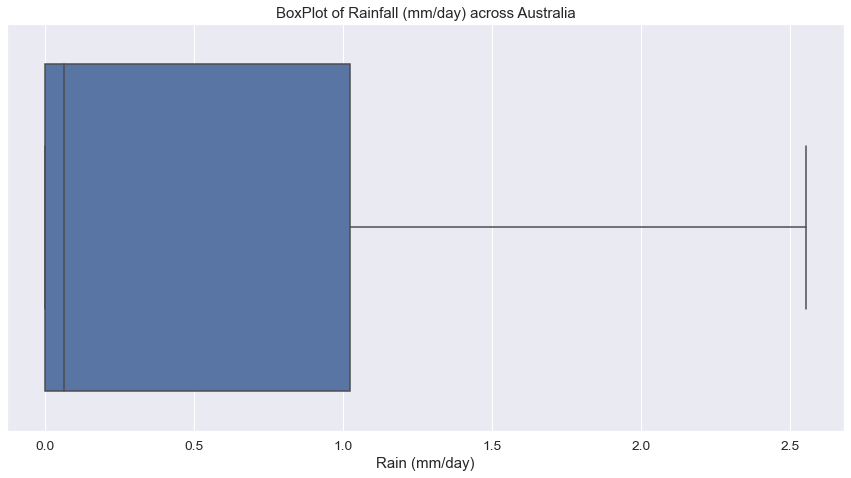

In [22]:
%%time
%%memit
sns.boxplot(x=df_float64['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

##### Pandas DataFrame `float32`:

peak memory: 5213.86 MiB, increment: 641.83 MiB
CPU times: user 1.92 s, sys: 362 ms, total: 2.28 s
Wall time: 2.75 s


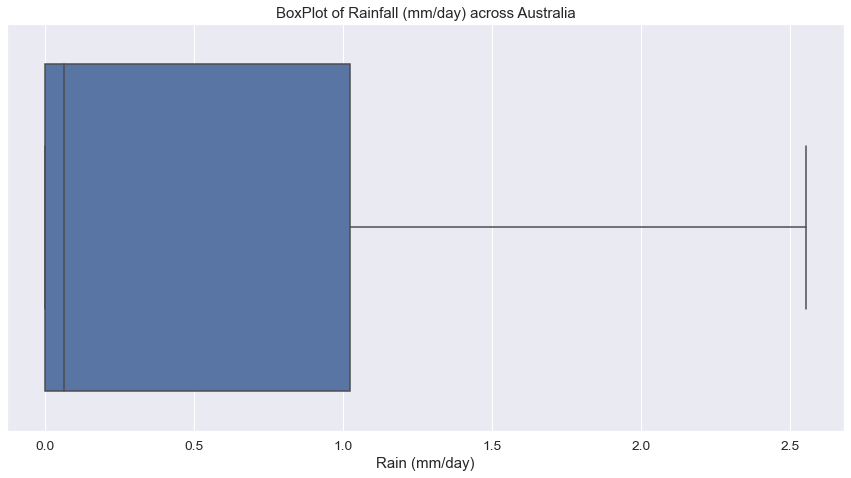

In [23]:
%%time
%%memit
sns.boxplot(x=df_float32['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

##### Dask DataFrame `float32`:

peak memory: 6539.55 MiB, increment: 2041.20 MiB
CPU times: user 4min 43s, sys: 1min 33s, total: 6min 16s
Wall time: 2min 3s


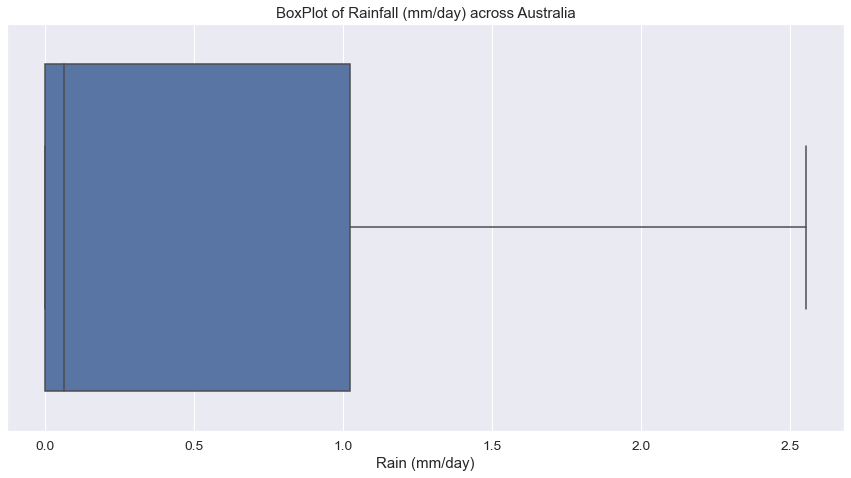

In [24]:
%%time
%%memit
sns.boxplot(x=ddf['rain (mm/day)'], showfliers=False);
plt.title("BoxPlot of Rainfall (mm/day) across Australia");
plt.xlabel("Rain (mm/day)");

##### Observations:

|                            | Peak Memory | CPU Time | Wall Time |
|:--------------------------:|:-----------:|:--------:|:---------:|
| Pandas DataFrame `float64` |  5824.61 MB           | 2.98s         |   3.66s        |
| Pandas DataFrame `float32` |  5213.86 MB           |  2.28s        |   2.75s        |
|  Dask DataFrame `float32`  |  6539.55 MB           |  6min 16s        |  2min 3s         |


When creating boxplots using `sns.boxplot`:
- The Peak Memory consumed is lower when using the Pandas DataFrame with `float32` numeric columns when compared with using the Pandas DataFrame with `float64` numeric columns
- The CPU and Wall Times are also lower when using the Pandas DataFrame with `float32` numeric columns when compared with using the Pandas DataFrame with `float64` numeric columns
- Interestingly, the Dask DataFrame with `float32` numeric columns consumes the most amount of Peak Memory and also has much higher CPU and Wall times when compared with the Panadas DataFrames

## 4. R Approaches For Data Transfer

### 4.1.1 Create Data Structures

#### Create table:

In [25]:
%%time
%%memit

dataset = ds.dataset("figsharerainfall/combined_data.csv", format="csv")
table = dataset.to_table()

peak memory: 6016.51 MiB, increment: 1642.31 MiB
CPU times: user 18.1 s, sys: 9.76 s, total: 27.9 s
Wall time: 24.8 s


#### Create Arrow Object:

In [26]:
%%time
%%memit
## Here we are loading the arrow dataframe that we have loaded previously
arrow_table = pyra.converter.py2rpy(table)

6709
rarrow.ChunkedArray: 0.02955913543701172
6709
rarrow.ChunkedArray: 0.02226996421813965
6709
rarrow.ChunkedArray: 0.02238297462463379
6709
rarrow.ChunkedArray: 0.022083044052124023
6709
rarrow.ChunkedArray: 0.019528865814208984
6709
rarrow.ChunkedArray: 0.02158808708190918
6709
rarrow.ChunkedArray: 0.02579784393310547
peak memory: 5059.82 MiB, increment: 254.54 MiB
CPU times: user 25.1 s, sys: 770 ms, total: 25.9 s
Wall time: 26.7 s


#### Create Feather File:

In [27]:
%%time
feather.write_feather(table, 'figsharerainfall/combined_data.feather')

CPU times: user 4.21 s, sys: 11.2 s, total: 15.4 s
Wall time: 5.76 s


In [28]:
%%sh
du -sh figsharerainfall/combined_data.feather

1.0G	figsharerainfall/combined_data.feather


#### Create Parquet File:

In [29]:
%%time 
pq.write_table(table, 'figsharerainfall/combined_data.parquet')

CPU times: user 9.92 s, sys: 691 ms, total: 10.6 s
Wall time: 10.7 s


In [30]:
%%sh
du -sh figsharerainfall/combined_data.parquet

544M	figsharerainfall/combined_data.parquet


|                            | Disk Usage | 
|:--------------------------:|:-----------:|
| `combined_data.csv` |  6.6G          |
| `combined_data.feather` |  1.0G          |
|  `combined_data.parquet`  |  544M        |

### 4.1.2 Transfer File Structure to R

#### Using Arrow Object:

In [31]:
%%time
%%R -i arrow_table
start_time <- Sys.time()
rview <- head(arrow_table)
summary_df <- glimpse(arrow_table)
model_count <- arrow_table %>% collect() %>% count(model)
end_time <- Sys.time()
print(class(arrow_table))
print(rview)
print(summary_df)
print(model_count)
print(end_time - start_time)

Classes 'Table', 'ArrowObject', 'R6' <Table>
  Inherits from: <ArrowObject>
  Public:
    .:xp:.: externalptr
    AddColumn: function (i, new_field, value) 
    cast: function (target_schema, safe = TRUE, options = cast_options(safe)) 
    clone: function (deep = FALSE) 
    column: function (i) 
    ColumnNames: function () 
    columns: active binding
    Equals: function (other, check_metadata = FALSE, ...) 
    field: function (i) 
    Filter: function (i, keep_na = TRUE) 
    GetColumnByName: function (name) 
    initialize: function (xp) 
    invalidate: function () 
    metadata: active binding
    num_columns: active binding
    num_rows: active binding
    pointer: function () 
    print: function (...) 
    RemoveColumn: function (i) 
    RenameColumns: function (value) 
    schema: active binding
    SelectColumns: function (indices) 
    serialize: function (output_stream, ...) 
    set_pointer: function (xp) 
    SetColumn: function (i, new_field, value) 
    Slice: functi

#### Using Feather File:

In [32]:
%%time
%%R
### her we are showing how much time it took to read a feather file what we wrote in python

start_time <- Sys.time()
r_table <- arrow::read_feather("figsharerainfall/combined_data.feather")
rview <- head(r_table)
summary_df <- glimpse(r_table)
model_count <- r_table %>% count(model)
end_time <- Sys.time()
print(class(r_table))
print(rview)
print(summary_df)
print(model_count)
print(end_time - start_time)

Rows: 62,513,863
Columns: 7
$ time            <dttm> 1889-01-01 17:21:10, 1889-01-02 17:21:10, 1889-01-03 …
$ lat_min         <dbl> -35.43987, -35.43987, -35.43987, -35.43987, -35.43987,…
$ lat_max         <dbl> -33.57462, -33.57462, -33.57462, -33.57462, -33.57462,…
$ lon_min         <dbl> 141.5625, 141.5625, 141.5625, 141.5625, 141.5625, 141.…
$ lon_max         <dbl> 143.4375, 143.4375, 143.4375, 143.4375, 143.4375, 143.…
$ `rain (mm/day)` <dbl> 4.244226e-13, 4.217326e-13, 4.498125e-13, 4.251282e-13…
$ model           <chr> "figsharerainfall/MPI-ESM-1-2-HAM", "figsharerainfall/…
[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 6 x 7
  time                lat_min lat_max lon_min lon_max `rain (mm/day)` model     
  <dttm>                <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>     
1 1889-01-01 17:21:10   -35.4   -33.6    142.    143.        4.24e-13 figsharer…
2 1889-01-02 17:21:10   -35.4   -33.6    142.    143.        4.22e-13 figsharer…
3 1889-01-03 17:21:10   -35

#### Using Parquet File:

In [33]:
%%time
%%R
start_time <- Sys.time()
r_table <- arrow::read_parquet("figsharerainfall/combined_data.parquet")
view <- head(r_table)
summary_df <- glimpse(r_table)
model_count <- r_table %>% count(model)
end_time <- Sys.time()
print(class(r_table))
print(view)
print(summary_df)
print(model_count)
print(end_time - start_time)

Rows: 62,513,863
Columns: 7
$ time            <dttm> 1889-01-01 17:21:10, 1889-01-02 17:21:10, 1889-01-03 …
$ lat_min         <dbl> -35.43987, -35.43987, -35.43987, -35.43987, -35.43987,…
$ lat_max         <dbl> -33.57462, -33.57462, -33.57462, -33.57462, -33.57462,…
$ lon_min         <dbl> 141.5625, 141.5625, 141.5625, 141.5625, 141.5625, 141.…
$ lon_max         <dbl> 143.4375, 143.4375, 143.4375, 143.4375, 143.4375, 143.…
$ `rain (mm/day)` <dbl> 4.244226e-13, 4.217326e-13, 4.498125e-13, 4.251282e-13…
$ model           <chr> "figsharerainfall/MPI-ESM-1-2-HAM", "figsharerainfall/…
[1] "tbl_df"     "tbl"        "data.frame"
# A tibble: 6 x 7
  time                lat_min lat_max lon_min lon_max `rain (mm/day)` model     
  <dttm>                <dbl>   <dbl>   <dbl>   <dbl>           <dbl> <chr>     
1 1889-01-01 17:21:10   -35.4   -33.6    142.    143.        4.24e-13 figsharer…
2 1889-01-02 17:21:10   -35.4   -33.6    142.    143.        4.22e-13 figsharer…
3 1889-01-03 17:21:10   -35


|                            | Emd Time - Start Time | CPU Time | Wall Time |
|:--------------------------:|:-----------:|:--------:|:---------:|
| Using Arrow Object |  7.617s          | 20.1s         |   7.79s        |
| Using Feather File |  22.245s           |  44.5s        |   23.1s        |
|  Using Parquet File  |  12.161s         |  20.3s        |  13.4s         |

### 4.2 Observations

After comparing these 3 methods:

- The time necessary to load in the data using the arrow object was very long, but once loaded, using the data was easy.

- It should be noted that rpy2-arrow is still fairly new, there is a lot of potential for this method of conversion.

- The columnar properties

We will pick parquet file format to transfer data from python to R. The reasons are listed as follows:

> 2- Using `feather` and `parquet` files compared to `csv` file, significantly improves both the time and memory usage.
  
> 3- Although the time usage for `parquet` is somewhat greater than that of `feather`, its memory usage is almost half of that for `feather`.
  
> 4- Loading the data in chunks results in reduced sys time and therefore the overall wall time is decreased.